In [136]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *
from data_path import data_path

In [137]:
# handle = sigmf.sigmffile.fromfile(data_path + '/772885KHz_3840KSPS_low_gain_blade.sigmf-data') # N_id_2 = 0, N_id_1 = 291, N_id = 873
# delta_f = 0e3
# f = 772.85e6
# mu = 0
# apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile(data_path + '/763450KHz_3840KSPS_low_gain_2.sigmf-data') #
# delta_f = -1e3
# f = 772.855e6
# mu = 0
# apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile(data_path + '/772885KHz_15360KSPS_low_gain.sigmf-data') # N_id_2 = 0, N_id_1 = 291, N_id = 873
# delta_f = 0e3
# f = 772.85e6
# mu = 0
# apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile(data_path + '/772885KHz_3840KSPS_low_gain.sigmf-data') # N_id_2 = 0, N_id_1 = 291, N_id = 873
# delta_f = -4e3
# f = 772.85e6
# mu = 0
# apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile(data_path + '/763MHz_15360KSPS.sigmf-data') # N_id_2 = 0, N_id_1 = 103, N_id = 309
# delta_f = 450e3
# f = 763e6
# mu = 0
# apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile(data_path + '/3627MHz_30720KSPS.sigmf-data')
# delta_f = -600e3
# f = 3672e6
# mu = 1
# apply_fine_CFO = 1

handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
delta_f = 0
f = 1
mu = 0
apply_fine_CFO = 0

waveform = handle.read_samples()
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)

In [138]:
waveform =  waveform * np.exp(-1j*2*np.pi*delta_f/fs*(np.arange(len(waveform))))

detected NID2 is 2 at 35264


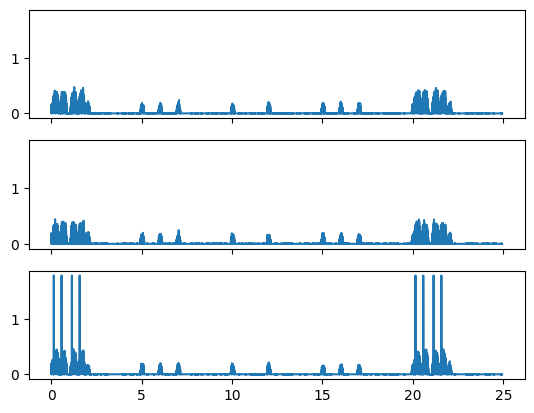

In [139]:
carrier = nrCarrierConfig(NSizeGrid = 106, SubcarrierSpacing = 15 * 2**mu)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']

peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
pssIndices = np.arange((635-63), (635+64))
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:, 0]
    slotGrid[pssIndices] = nrPSS(current_NID2)
    [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, SampleRate = fs)
    refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

    temp = scipy.signal.correlate(waveform[:int(25e-3 * fs)], refWaveform, 'valid')  # correlate over 25 ms
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/fs*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)
print(f'detected NID2 is {detected_NID2} at {peak_index[detected_NID2]}')

In [151]:
nrbSSB = 20
scsSSB = 15 * 2**(mu)
nSlot = 0
rxSampleRate = fs
if False:
    cp1 = np.round(5.2e-6*fs * 2**(-mu))
    cp2 = np.round(4.7e-6*fs * 2**(-mu))
    timingOffset = int(35264 - 2048 - cp1 - cp2)
else:
    nrbSSB = 20
    refGrid = np.zeros((nrbSSB*12, 2))
    refGrid[nrPSSIndices(), 1] = nrPSS(detected_NID2)
    timingOffset = nrTimingEstimate(waveform = waveform, nrb = nrbSSB, scs = scsSSB, initialNSlot = nSlot, refGrid = refGrid, SampleRate = rxSampleRate)
    print(timingOffset)

In [141]:
# modulate about 8 symbols, only has to be at least 5
rxGrid = nrOFDMDemodulate(waveform = waveform[timingOffset:][:np.min((len(waveform), 2048*8))], nrb = nrbSSB, scs = scsSSB, initialNSlot = nSlot, SampleRate=rxSampleRate)
rxGrid = rxGrid[:,1:5]
rxGrid /= np.max((rxGrid.real.max(), rxGrid.imag.max()))

Text(0.5, 0.95, 'SSS symbols')

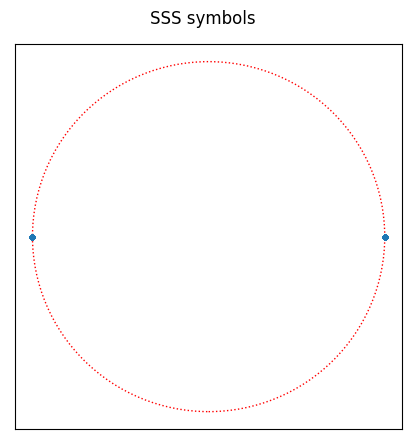

In [142]:
sssIndices = nrSSSIndices()
sssRx = nrExtractResources(sssIndices, rxGrid)
sssRx /= np.max((sssRx.real.max(), sssRx.imag.max())) # scale sssRx symbols individually

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(sssRx.real, sssRx.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols', y=0.95)

detected NID1 is 69
detected NID is 209


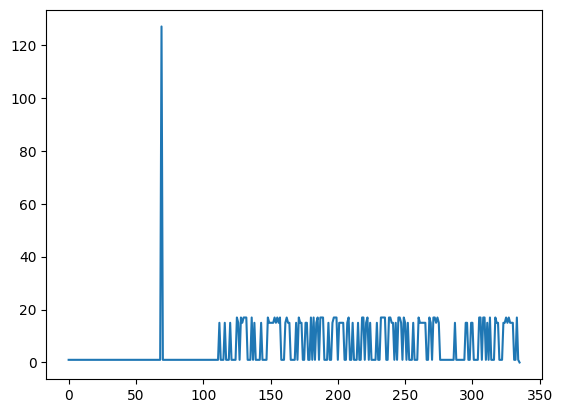

In [143]:
sssEst = np.zeros(336)
for NID1 in range(335):
    ncellid = (3*NID1) + detected_NID2
    sssRef = nrSSS(ncellid)
    sssEst[NID1] = np.abs(np.vdot(sssRx, sssRef))

detected_NID1 = np.argmax(sssEst)
detected_NID = detected_NID1*3 + detected_NID2
print(f'detected NID1 is {detected_NID1}')
print(f'detected NID is {detected_NID}')
plt.plot(sssEst)
plt.show()

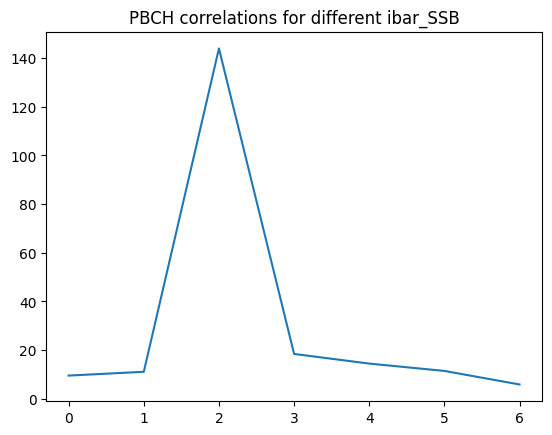

ibar_SSB is 2


In [144]:
dmrsIndices = nrPBCHDMRSIndices(detected_NID, style='matlab')
xcorrPBCHDMRS = np.empty(7)
for ibar_SSB in range(7):
    PBCHDMRS = nrPBCHDMRS(detected_NID, ibar_SSB)
    xcorrPBCHDMRS[ibar_SSB] = np.abs(np.vdot(nrExtractResources(dmrsIndices, rxGrid), PBCHDMRS))
ibar_SSB = np.argmax(np.abs(xcorrPBCHDMRS))

plt.plot(np.abs(xcorrPBCHDMRS))
plt.title('PBCH correlations for different ibar_SSB')
plt.show()
print(f'ibar_SSB is {ibar_SSB}')

In [145]:
refGrid = np.zeros((nrbSSB*12, 4), 'complex')
dmrsIndices = nrPBCHDMRSIndices(detected_NID)

if False:
    refGridFlat = refGrid.ravel(order='F')
    refGridFlat[dmrsIndices] = nrPBCHDMRS(detected_NID, ibar_SSB)
    refGrid = refGridFlat.reshape(refGrid.shape, order='F')

    refGridFlat = refGrid.ravel(order='F')
    refGridFlat[sssIndices] = nrSSS(detected_NID)
    refGrid = refGridFlat.reshape(refGrid.shape, order='F')
else:
    nrSetResources(dmrsIndices, refGrid, nrPBCHDMRS(detected_NID, ibar_SSB))

Text(0.5, 0.95, 'wiped PBCHDMRS symbols')

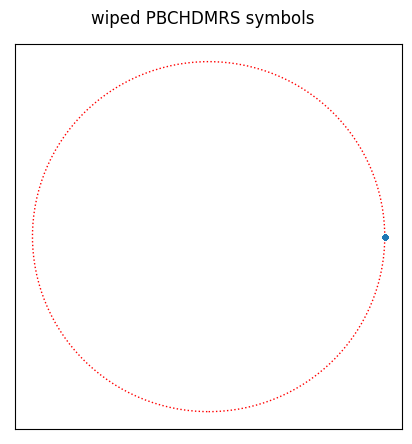

In [146]:
PBCHDMRS_wiped = nrExtractResources(dmrsIndices, rxGrid) / nrExtractResources(dmrsIndices, refGrid)

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(PBCHDMRS_wiped.real, PBCHDMRS_wiped.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('wiped PBCHDMRS symbols', y=0.95)

/mnt/d/git/py3gpp/py3gpp/nrChannelEstimate.py:25: RuntimeWarning: divide by zero encountered in divide
  normGrid = rxGrid / refGrid


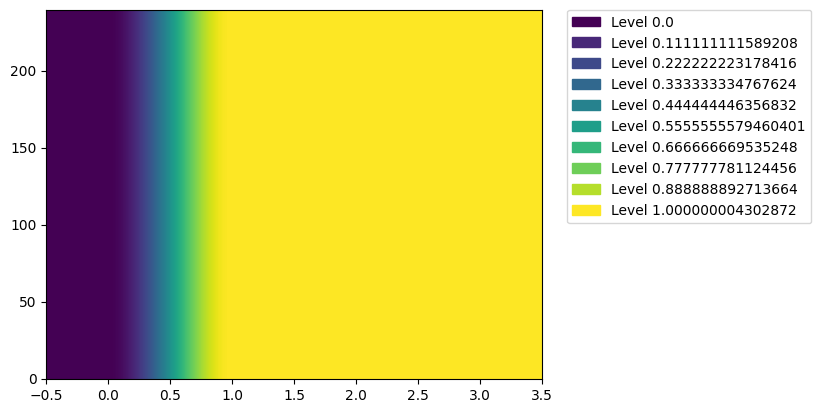

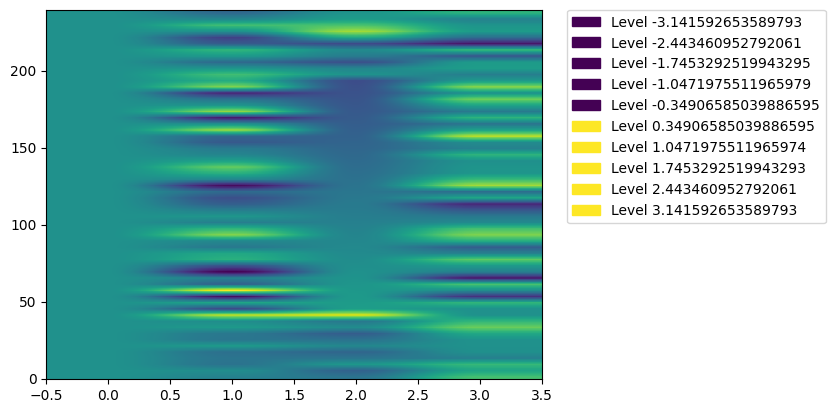

In [147]:
import matplotlib.patches as mpatches 
H, nVar = nrChannelEstimate(rxGrid = rxGrid, refGrid = refGrid)
im = plt.imshow(np.abs(H), origin='lower', aspect='auto')
values = np.linspace(np.min(np.abs(H)), np.max(np.abs(H)), 10)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

im = plt.imshow(np.angle(H), origin='lower', aspect='auto')
values = np.linspace(-np.pi, np.pi, 10)
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/tmp/ipykernel_32048/2716898170.py:1: RuntimeWarning: divide by zero encountered in divide
  PBCHDMRS_wiped = nrExtractResources(dmrsIndices, rxGrid/H)


Text(0.5, 0.95, 'equilized PBCHDMRS symbols')

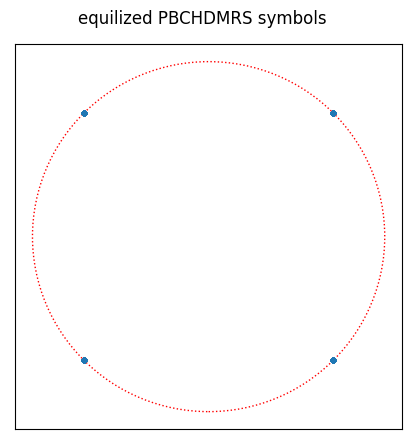

In [148]:
PBCHDMRS_wiped = nrExtractResources(dmrsIndices, rxGrid/H)

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(PBCHDMRS_wiped.real, PBCHDMRS_wiped.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('equilized PBCHDMRS symbols', y=0.95)

Text(0.5, 0.95, 'equilized PBCH symbols')

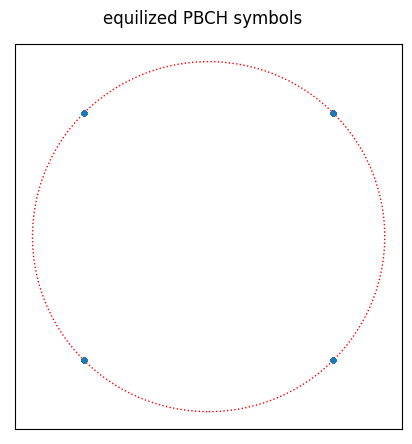

In [149]:
pbchIndices = nrPBCHIndices(detected_NID)
pbch_eqed, csi = nrEqualizeMMSE(nrExtractResources(pbchIndices, rxGrid), nrExtractResources(pbchIndices, H), nVar)

fig, axs = plt.subplots(1, 1, figsize=(5, 5), facecolor='w', sharex=True, sharey=True)
axs.plot(pbch_eqed.real, pbch_eqed.imag, '.')
axs.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
axs.set_xticks([])
axs.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('equilized PBCH symbols', y=0.95)

In [150]:
pbchBits = nrSymbolDemodulate(pbch_eqed, 'QPSK', nVar, 'soft')
E = 864
v = ibar_SSB
scrambling_seq = nrPBCHPRBS(detected_NID, v, E)
scrambling_seq_bpsk = (-1)*scrambling_seq*2 + 1
pbchBits_descrambled = pbchBits * scrambling_seq_bpsk
pbchBits_csi = pbchBits_descrambled * np.repeat(csi, 2)

A = 32
P = 24
K = A+P
N = 512 # calculated according to Section 5.3.1 of 3GPP TS 38.212
decIn = nrRateRecoverPolar(pbchBits_csi, K, N)

# values from Matlab for 3627MHz_30720KSPS
# decIn = np.array([98.0994, 100.2936, -100.1615, -111.2452, -101.7249, -101.5950, 78.5901, -77.7265, -76.4686, -81.3223, -115.8069, 89.6047, 85.9367, 104.1048, -98.2053, -106.7203, 83.1207, 88.2861, 83.8204, -109.2175, -124.4919, 94.6728, 91.5959, -89.5352, -101.8143, -123.6915, -103.1579, -108.0879, 100.9417, -95.5231, 122.5312, 99.6845, -78.9441, 115.9421, 65.5815, 90.9532, -88.9573, -85.7132, -83.5216, -78.7969, -54.1358, 75.8672, 84.9239, -89.5731, -92.8101, -76.0732, 72.9594, -74.3997, 93.8353, -80.0016, 83.2706, -104.8245, 75.5381, -89.3799, 86.4390, 84.6055, 43.8157, -100.4702, -79.0332, -89.0215, 109.9606, -99.6110, 111.9779, -101.8772, -68.2989, 93.4047, 95.1260, 79.8283, 80.2065, -89.3344, 68.9841, -77.7767, 95.8681, -79.4709, 62.2583, -63.4266, -91.1614, 81.0331, -83.1753, -95.7477, 79.3811, -78.2227, 109.3239, -70.7376, -90.1096, -93.8385, -83.5296, 79.8664, -107.2777, 86.7808, -83.8104, -89.5405, 83.9844, 88.8928, -114.4005, -81.6010, 68.2572, 100.1189, -94.9682, -106.6306, 94.3960, -75.7935, -80.0656, -80.4422, 80.0088, 78.5461, -101.9442, 101.2641, 79.4489, -82.3328, 85.9272, -93.2934, 96.1777, 88.5216, 84.3977, -82.6021, 84.0117, 95.0405, -86.1691, -74.1916, 108.7456, 86.4657, -75.5564, -99.4773, 74.5251, 98.5329, -83.2432, 70.5688, -68.4671, -79.3403, -62.6724, -60.8476, 67.8379, 91.1800, 87.8499, -101.2957, -69.6481, -74.5603, 70.1766, -99.2101, 101.3056, 57.1986, 87.5917, 84.1423, -66.9824, -62.7680, 60.1339, -78.9674, 65.3749, -64.6940, 50.0190, -89.6008, -59.3167, -63.1129, 61.5982, 48.8499, 65.2957, -44.2573, -67.7464, -87.8192, 73.3080, -55.5333, 61.1872, 83.1372, 72.6622, 56.7458, -90.9942, -99.5641, -62.1492, 75.1305, -67.2248, 82.1078, -71.9184, -96.0142, -82.4769, 63.0060, -78.2155, 88.4656, 78.1025, -62.1181, -66.5374, 74.3818, 84.9285, 65.4854, 60.3368, -59.9013, 62.8409, 45.3090, 58.8132, -90.1745, -80.5019, 76.9129, 53.0226, -60.5902, 68.6878, 71.6496, -79.5789, 68.2251, 69.2261, -57.2262, 67.4926, -56.8821, -78.9174, 54.9742, -77.1147, 72.3281, 45.8284, 74.1518, -96.2469, 74.1641, 71.7959, -84.9770, 75.2968, 43.3046, -75.7478, 79.3113, -67.3357, 83.5540, 88.1043, 92.9397, 60.5756, 96.0108, 68.6091, 56.8510, -81.4292, -84.7288, -61.2944, -77.7179, -74.2870, 73.8435, -68.7351, -50.0336, 55.0304, 84.1329, 68.3470, -42.6786, 51.2943, -66.9083, -66.1926, 79.1121, -59.2044, -69.6405, 89.3530, -68.6773, -78.4004, -57.7046, -56.9396, -56.8815, 84.8120, 85.3458, 72.9297, 90.6085, 110.8704, 81.9232, 78.7975, -75.6312, -76.4349, -65.0490, 66.5703, 77.3265, 70.3819, 58.6750, -61.8244, 94.9379, 68.1455, 80.8718, 71.4065, -89.3790, -42.6856, -64.9363, 76.2369, 69.3416, -64.3863, -64.0232, -58.3138, 79.5344, 67.9879, -79.1206, -79.1714, 60.2715, 72.0637, 87.6743, 87.1759, 81.4093, -74.1212, 100.5560, -82.5535, -56.7645, 90.7906, -100.7988, -64.6227, -98.9736, 89.3586, 78.5604, 99.6034, 55.0377, 83.2926, -72.7276, -98.3970, 71.7933, 61.7939, 67.9014, -69.5731, 73.2906, -70.8013, 63.1397, -52.9220, 80.8111, -76.1652, 76.7023, -66.0006, -52.8898, -67.6308, 85.2930, 78.6230, 75.2349, -75.5770, 61.5977, -82.0592, 56.5244, 73.6083, -91.9549, -48.5210, -68.8685, -87.2434, 55.9644, -90.2183, 76.1801, -85.3346, 66.5699, -93.3345, 46.6941, 74.9255, -85.1393, 65.0381, 59.5640, -65.9826, 84.1422, -68.0985, 74.0803, 66.0246, 83.8283, 78.7515, -80.7086, 52.4481, -66.9362, 56.3773, 65.2047, -60.8237, -76.4423, 79.9544, 76.8582, -76.3870, -74.6423, 50.1182, 43.6267, -69.2405, 65.5949, 78.9524, 64.1765, -55.5729, -64.7979, 61.4107, -74.2137, -74.3217, 62.0394, -74.1537, 69.4664, -96.5727, -98.9427, -77.9188, 81.6283, -92.4196, -81.5016, 116.7946, 111.1792, -104.2775, -102.8753, 105.5464, 73.3699, -121.8863, -83.9218, 99.9105, -76.7338, 71.2199, 84.3709, 123.7199, 78.3144, -110.0666, -102.4246, -94.3307, 82.9367, 96.7602, 97.7912, -85.7501, 88.8595, -71.4018, -73.5545, -58.8523, -103.0843, 97.3005, 78.5062, -109.6570, 85.2691, -91.4737, 87.4685, -87.5806, 106.0338, 76.4113, 112.0384, -78.9545, -67.7884, -70.9985, 84.6570, 98.7297, 91.5841, -83.0778, 108.2129, -94.8490, -87.3756, -111.9341, -86.7001, 95.5885, 115.4110, 72.8125, -106.4446, 80.6854, -90.9581, 87.6573, 68.6028, 103.3637, -92.1900, 73.5025, -53.7392, -64.1919, 106.1772, 79.7842, -69.1110, -79.4048, -98.8703, -57.1228, 62.4514, -93.6077, -45.7700, -68.4287, 71.8675, 66.7427, -63.6768, -74.7351, 68.3605, -64.5109, -86.4599, 92.2079, -62.3135, -47.5140, 74.8112, -55.6607, 72.2295, 98.2756, -54.4462, 104.4787, -76.8929, -84.0509, -87.5470, 88.1545, -38.5373, -73.9172, 86.9245, -65.0378, -62.6790, 76.2379, -54.8815, 70.4215, -64.9437, -64.9268, -78.1091, -52.9684, -53.5112, -67.4531, -47.4951, 54.0182, 62.7692, 47.2771, 64.6934, 62.8590, -63.9107, 52.5923, 69.3743, -64.8862, -76.7852, -60.9050, 51.3035, -61.0244, 75.3462, 66.0729, -50.1459, 61.4202, 80.4490, -65.3638, 65.9481, 66.2290, 68.6534, 48.4402, 76.8827, -88.6572, -102.7420, -94.8729, -128.7776, -122.5039, -111.4672, -105.0354, 107.5132])

if False:
    from sionna.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
    from sionna.fec.polar.utils import generate_5g_ranking

    def interleave(K):
        # 38.212 Table 5.3.1.1-1
        p_IL_max_table = [0, 2, 4, 7, 9, 14, 19, 20, 24, 25, 26, 28, 31, 34, 42, 45, 49, 50, 51, 53, 54, 56, 58, 59, 61, 62, 65, 66, 67, 69, 70, 71, 72, 76, 77, 81, 82, 83, 87, 88, 89, 91, 93, 95, 98, 101, 104, 106, 108, 110, 111, 113, 115, 118, 119, 120, 122, 123, 126, 127, 129, 132, 134, 138, 139, 140, 1, 3, 5, 8, 10, 15, 21, 27, 29, 32, 35, 43, 46, 52, 55, 57, 60, 63, 68, 73, 78, 84, 90, 92, 94, 96, 99, 102, 105, 107, 109, 112, 114, 116, 121, 124, 128, 130, 133, 135, 141, 6, 11, 16, 22, 30, 33, 36, 44, 47, 64, 74, 79, 85, 97, 100, 103, 117, 125, 131, 136, 142, 12, 17, 23, 37, 48, 75, 80, 86, 137, 143, 13, 18, 38, 144, 39, 145, 40, 146, 41, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163]
        k = 0
        K_IL_max = 164
        p = np.empty(K, 'int')
        for p_IL_max in p_IL_max_table:
            if p_IL_max >= (K_IL_max - K):
                p[k] = p_IL_max - (K_IL_max - K)
                k += 1
        return p    

    # decode
    frozen_pos, info_pos = generate_5g_ranking(K, N)
    decoder = PolarSCLDecoder(frozen_pos, N, list_size=8, crc_degree='CRC24C', cpu_only=True, use_fast_scl=False)
    #decoder = PolarSCDecoder(frozen_pos, N)
    decoded = np.array(decoder(np.expand_dims(decIn, 0))[0], 'int')

    # deinterleave
    p_IL = interleave(K)
    decoded2 = np.empty(decoded.shape, 'int')
    np.put(decoded2, p_IL, decoded)

    # check CRC
    decoded3, crc_result = nrCRCDecode(decoded2, '24C')
    if crc_result:
        print("PBCH CRC ok")
    else:
        print("PBCH CRC failed")

decoded = nrPolarDecode(decIn, K, 0, 0)

# check CRC
decoded3, crc_result = nrCRCDecode(decoded, '24C')
if crc_result:
    print("PBCH CRC ok")
else:
    print("PBCH CRC failed")

PBCH CRC failed
